In [7]:
from database.utils import reconstruct_probs
from models.SVM.binary_classification import tune_hyperparams, perform_skfold, optimise_score_over_channels, manual_y_predict, average_probabilities
from models.scoring_metrics import scoring_function, print_scores_for_channel, get_av_confusion_matrix
from database.data import Data
from sklearn.svm import SVC
from tqdm import tqdm
import numpy as np


In [2]:
#creating DATA object
ptb_binary_SVM = Data(database = 'ptbdb', denoise_method='DWT', estimation_method = 'SVM', train_splits=None, binary = True, parameterisation = True)


# define hyperparameter grid to test
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale']#including 'auto' aswell takes forever
}


In [8]:
repeats = 1

best_scores = []
best_channels = []

optimal_probs = []


#nan_indices_list = []
av_thresholds_list = []

scores_dict_list = []


for j in tqdm(range(repeats)):

    ptb_binary_SVM.run()

    input_data = ptb_binary_SVM.input_data
    labels = ptb_binary_SVM.labels
    
    metrics = {}
    
    probs_list = []
    thresholds_list = []

    for i in range(6):
        labels_encoded = np.array([0 if label == 'Unhealthy' else 1 for label in labels[i]])

        #define classifier
        svc = SVC(class_weight='balanced', probability = True)

        #find the best set of hyperparameters for each channel, tuned on the desired scoring function
        best_svc = tune_hyperparams(input_data[i], labels_encoded, param_grid, svc, scorer='balanced_accuracy')

        #perform 3 way skfold to get scores for each channel as well as their probabilities
        n_splits = 3
        all_score_metrics, thresholds, probabilities, y_tests, test_indices = perform_skfold(input_data[i], labels_encoded, n_splits, best_svc, get_probabilities=True)

        #monitoring scores for each channel
        metrics[i] = all_score_metrics

        #calculating average threshold from all splits
        threshold = np.mean(thresholds)

        #reconstructing calculated probabilities so can optimise over all channels
        reconstructed_probs = reconstruct_probs(probabilities, test_indices, ptb_binary_SVM.nan_indices[i], ptb_binary_SVM.allowed_patients.count_patients(), n_splits)


        #need for ROC curve and confusion matrix later
        probs_list.append(reconstructed_probs)
        thresholds_list.append(threshold)

    


    #for averaging 
    scores_dict_list.append(metrics)

    #optimising over channels
    av_threshold = np.mean(thresholds_list)
    best_score, best_channel_indices = optimise_score_over_channels(probs_list, av_threshold, ptb_binary_SVM.health_state)

    best_scores.append(best_score)
    best_channels.append(best_channel_indices)


    #calculating optimal probability
    best_prob = average_probabilities(probs_list, best_channel_indices)
    optimal_probs.append(best_prob)
    av_thresholds_list.append(av_threshold)


  0%|          | 0/1 [00:00<?, ?it/s]

Filtering Database


100%|██████████| 221/221 [00:03<00:00, 58.94it/s]


denoising signals through Discrete Wavelet Transform
normalising signals
calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['RMSSD', 'mean', 'sd2', 'age']
Selected features for channel 2:
['rr_amps', 'sd_ratio', 'sd2', 'age']
Selected features for channel 3:
['rr_amps', 'skews', 'shannon_en', 'age']
Selected features for channel 4:
['rr_amps', 'std', 'skews', 'age']
Selected features for channel 5:
['skews', 'lf', 'shannon_en', 'age']
Selected features for channel 6:
['mean', 'lf', 'sd2', 'age']


100%|██████████| 1/1 [02:22<00:00, 142.23s/it]


## Averaged Channel Scores

In [10]:
# Initialize an empty dictionary to store averaged scores
averaged_scores = {}

# Iterate through each channel in the dictionaries
for channel in scores_dict_list[0].keys():
    averaged_scores[channel] = {}
    for metric in scores_dict_list[0][channel].keys():
        # Calculate the average of the current metric for the current channel
        values = [score[channel][metric] for score in scores_dict_list]
        mean_value = np.mean(values)
        std_value = np.std(values)
        averaged_scores[channel][metric] = (mean_value, std_value)

# Print the averaged scores with 2 decimal places
for channel, scores in averaged_scores.items():
    print(f'Channel {channel + 1}:')
    for metric, (mean_value, std_value) in scores.items():
        print(f'  {metric}: {mean_value:.2f} ± {std_value:.2f}')
    print()


Channel 1:
  F1 score: 0.53 ± 0.00
  Objective score: 0.59 ± 0.00
  Bal Acc: 0.72 ± 0.00
  Accuracy: 0.70 ± 0.00
  precision: 0.41 ± 0.00
  recall: 0.75 ± 0.00

Channel 2:
  F1 score: 0.52 ± 0.00
  Objective score: 0.58 ± 0.00
  Bal Acc: 0.72 ± 0.00
  Accuracy: 0.66 ± 0.00
  precision: 0.38 ± 0.00
  recall: 0.82 ± 0.00

Channel 3:
  F1 score: 0.51 ± 0.00
  Objective score: 0.57 ± 0.00
  Bal Acc: 0.72 ± 0.00
  Accuracy: 0.68 ± 0.00
  precision: 0.38 ± 0.00
  recall: 0.80 ± 0.00

Channel 4:
  F1 score: 0.48 ± 0.00
  Objective score: 0.54 ± 0.00
  Bal Acc: 0.68 ± 0.00
  Accuracy: 0.69 ± 0.00
  precision: 0.39 ± 0.00
  recall: 0.65 ± 0.00

Channel 5:
  F1 score: 0.52 ± 0.00
  Objective score: 0.58 ± 0.00
  Bal Acc: 0.71 ± 0.00
  Accuracy: 0.78 ± 0.00
  precision: 0.48 ± 0.00
  recall: 0.59 ± 0.00

Channel 6:
  F1 score: 0.50 ± 0.00
  Objective score: 0.57 ± 0.00
  Bal Acc: 0.71 ± 0.00
  Accuracy: 0.66 ± 0.00
  precision: 0.37 ± 0.00
  recall: 0.80 ± 0.00



## Optimised Channel Scores

In [11]:
print(np.mean(best_scores))
print(np.std(best_scores))

print(best_channels)

0.5691056910569106
0.0
[[0, 2, 4]]


## Classification Report for best

In [23]:
from sklearn.metrics import classification_report

nan_indices = np.isnan(optimal_probs[i])

health_state = ptb_binary_SVM.health_state
encoded_health_state = np.array([0 if label == 'Unhealthy' else 1 for label in health_state])

y_pred = (optimal_probs[0] > threshold).astype(int)

print(classification_report(encoded_health_state[~nan_indices], y_pred[~nan_indices]))

              precision    recall  f1-score   support

           0       0.92      0.76      0.84       173
           1       0.46      0.76      0.57        46

    accuracy                           0.76       219
   macro avg       0.69      0.76      0.70       219
weighted avg       0.83      0.76      0.78       219



## ROC CURVE

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


average_tprs = []
average_aucs = []

for i in range(repeats):

    #first need to find nan values in each optimised prob
    nan_indices = np.isnan(optimal_probs[i])

    probs_for_roc = optimal_probs[i][~nan_indices]
    y_test = health_state[~nan_indices]
    

    # computing ROC params
    fpr, tpr, _ = roc_curve(y_test, probs_for_roc, pos_label='Healthy')


    #need to interpolate everything so they are the desired length
    mean_fpr = np.linspace(0, 1, 230)#put max length of array in here in a sec

    interp_tpr = np.interp(mean_fpr, fpr, tpr)


    roc_auc = auc(mean_fpr, interp_tpr)

    average_tprs.append(interp_tpr)
    average_aucs.append(roc_auc)

mean_tpr = np.mean(average_tprs, axis = 0)
std_tpr = np.std(average_tprs, axis=0)

mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(average_aucs)



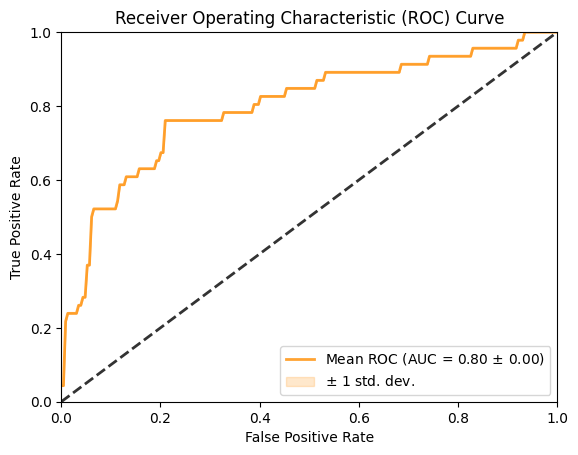

In [25]:
# plotting average ROC curve for all iterations
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='darkorange', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('figures\\ROC_curve.png', bbox_inches='tight')
plt.show()

## Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
manual_y_preds = []
confusion_matrix_list = []
y_tests_combined_list = []
for j in range(repeats):
    #first need to find nan values in each optimised prob
    nan_indices = np.isnan(optimal_probs[j])

    
    encoded_health_state = np.array([0 if label == 'Unhealthy' else 1 for label in health_state])
    y_test = encoded_health_state[~nan_indices]

    y_pred = (optimal_probs[j] > threshold).astype(int)#will be threshold[j] when do repeats

    confusion_matrix_list.append(confusion_matrix(y_test, y_pred[~nan_indices]))

print(confusion_matrix_list)
average_confusion_matrix = np.mean(confusion_matrix_list, axis=0)
print(average_confusion_matrix)


[array([[132,  41],
       [ 11,  35]], dtype=int64)]
[[132.  41.]
 [ 11.  35.]]


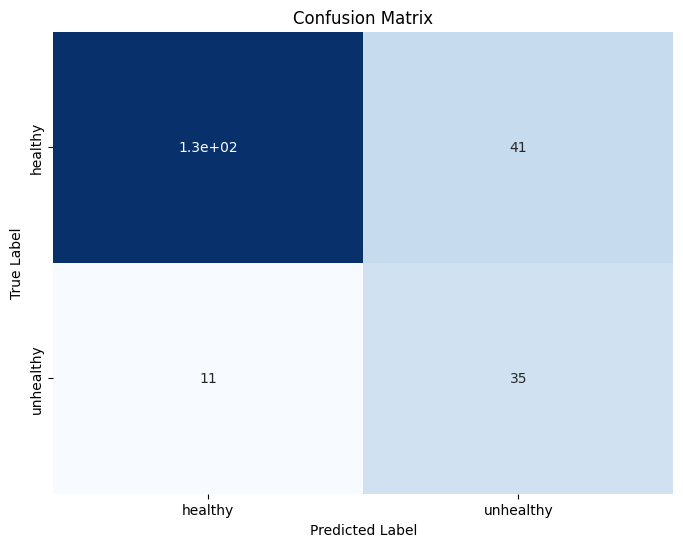

In [30]:
import seaborn as sns

target_names = ['healthy', 'unhealthy']
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))

ax = sns.heatmap(average_confusion_matrix, annot=True, cmap='Blues', cbar=False, 
                 xticklabels=target_names, 
                 yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig('figures\\confusion_matrix.png', bbox_inches='tight')
plt.show()

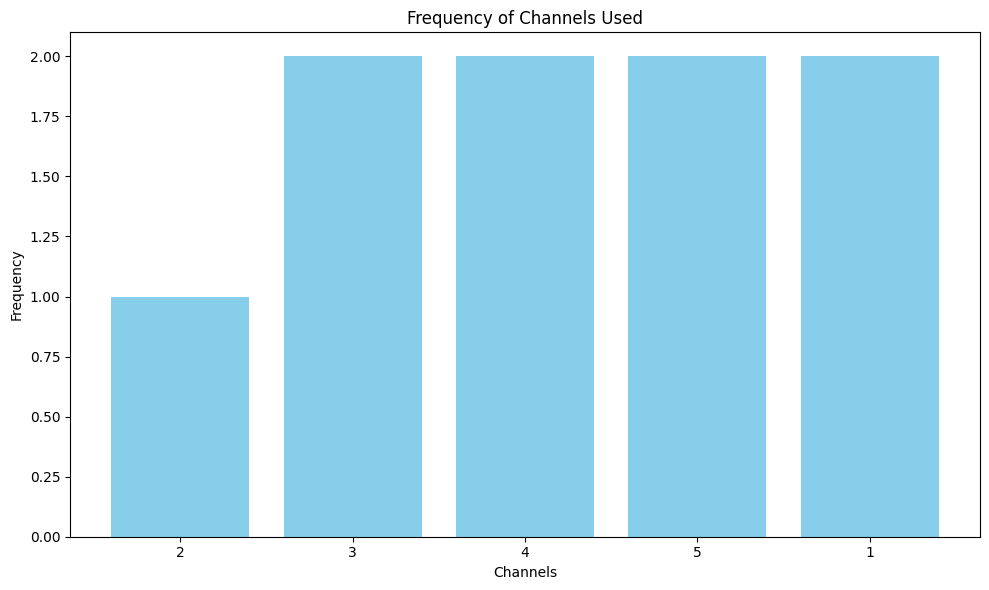

In [41]:
import matplotlib.pyplot as plt
from collections import Counter


# Flatten the list of lists
flattened_list = [number for sublist in best_channels for number in sublist]

# Count the occurrences of each number
counted_numbers = Counter(flattened_list)

# Sort the numbers to maintain a consistent order in the plot
sorted_numbers = sorted(counted_numbers.keys())
counts = [counted_numbers[number] for number in sorted_numbers]

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(sorted_numbers, counts, color='skyblue')

# Adding labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Channels Used')
ax.set_xticks(sorted_numbers)
ax.set_xticklabels(counted_numbers.keys())

# Show the plot
plt.tight_layout()
plt.savefig('figures\\number_frequency_bar_chart.png', bbox_inches='tight')
plt.show()